# Midterm Exam Data Analysis
This analysis uses a fictional data set of midterm exam scores to test different analyses of a data set.  It simulates the midterm exam scores given at three high schools in a larger network of schools.  The data set includes the following:
- Student exam scores for midterm exams in different subjects, given at at three high schools.  It includes the name of the high school and student's teacher.
- Average scores and standard deviations for the larger network of schools, of which these students are a subset.  

By comparing the school's exam results to the network data, these recommendations can be made:  
- On **Curriculum**: 
    - The majority of students in **AP English Language**, **English III**, **AP US History**, and **Physics** score above the network averages on the respective exams.  These curriculums may be particularly strong, and examining them for key qualities may be beneficial.  
- On **Teacher Preparation**:  
    - Within the same course, there can be a wide variation in student performance by teacher.  Some teachers may be highly experienced, while others may arrive midyear and are still becoming familiar with the curriculum.  Learning from the highly experienced teachers and supporting newer teachers may help.  
- On **Student Preparation**:
    - After accounting the factors listed above, student preparation still has a large affect on outcome.  When taking the same class, students in the honors track generally score better than students in the general education track.  

## Student Results
After loading score results from the school and network levels, we compare student results by subject test. 
- Students in **AP English Language**, **English III**, **AP US History**, and **Physics** score **above** the network average in the respective subjects.  These curriculums and teachers may be particularly strong, and may merit follow up.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

df_usi_scores = pd.read_csv("Data/midterm_results.csv")
df_usi_Teacher = pd.read_csv("Data/teachers.csv")
df_usi_Student_Roster = pd.read_csv("Data/student_roster.csv")

df_usi_Teacher.columns = ["Subject", "School", "Teacher"]
df_usi_Teacher
df_usi_Student_Roster.columns = ["Student_Number", "School"]
df_usi_scores.drop_duplicates(inplace=True)

df = pd.merge(left=df_usi_scores, right=df_usi_Student_Roster, left_on="Student_Number", right_on="Student_Number")
df = pd.merge(left=df, right=df_usi_Teacher, left_on=["School", "Subject"], right_on=["School", "Subject"])

In [6]:
df_cb = pd.read_excel("Data/midterm-score-distributions-by-subject-2024.xlsx", header=2, nrows=11)
df_cb = df_cb.drop([0,1,7,8], axis=0).set_index("Exam Score")
df_cb = df_cb[["AP Seminar", "Physics", "AP Chemistry", "English III", "AP English Language", "Honors US History"]]

temp = pd.read_excel("Data/midterm-score-distributions-by-subject-2024.xlsx", header=14, nrows=11)
temp.drop([0,1,7,8], inplace=True)
temp.set_index("Exam Score", inplace=True)
df_cb = pd.concat([df_cb, temp[["AP US History"]]], axis=1)

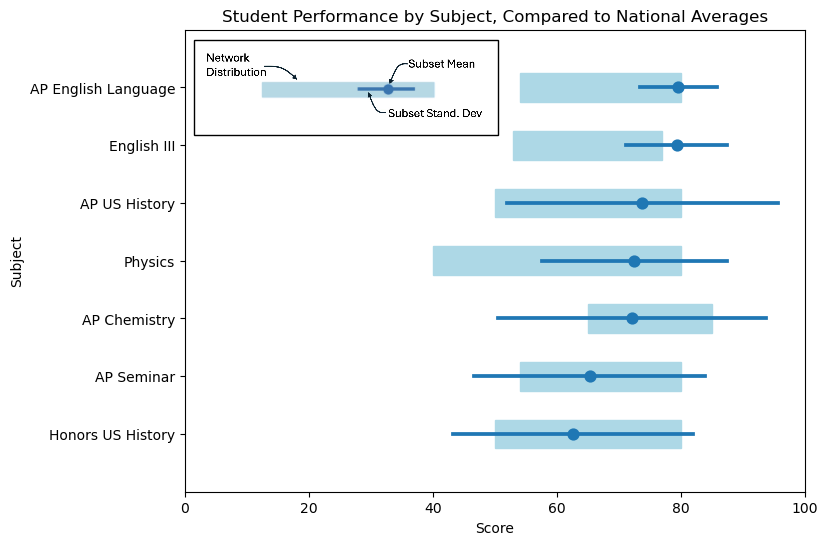

In [9]:
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

fig, ax = plt.subplots(figsize=[8,6])
df_ave = df[["Subject", "Score"]].groupby("Subject").mean()
order = df_ave.sort_values(ascending=False, by="Score").index

sns.pointplot(df, x="Score", y="Subject", linestyles="none", order=order, ax=ax, errorbar='sd')

y_labels = ax.yaxis.get_ticklabels()

for label in y_labels:
    national_ave = df_cb.loc["Mean Score", label.get_text()]
    national_std = df_cb.loc["Standard Deviation", label.get_text()]
    position = label.get_position()
    rect = patches.Rectangle((national_ave-national_std, position[1]-0.25), 
                             2*national_std, 0.5, facecolor='#ADD8E6', edgecolor='#ADD8E6')
    ax.add_patch(rect)

ax.set_xlim((0,100))
ax.set_ylim((7,-1))
ax.set_title("Student Performance by Subject, Compared to National Averages");

file = "Images/key.jpg"
key = image.imread(file)

imagebox = OffsetImage(key, zoom = 0.16)
ab = AnnotationBbox(imagebox, (26,0), frameon=True)
ax.add_artist(ab)

fig.savefig("Images/SubjectAve.jpg", bbox_inches='tight')


# The Effect of a Teacher
We also see a large variation in scores by teacher in Physics, Honors US History, AP Chemistry, and AP US History.  Teacher experience and support may play a factor in determining these exam scores.

/Users/jgoett/anaconda3/envs/jeff-env/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


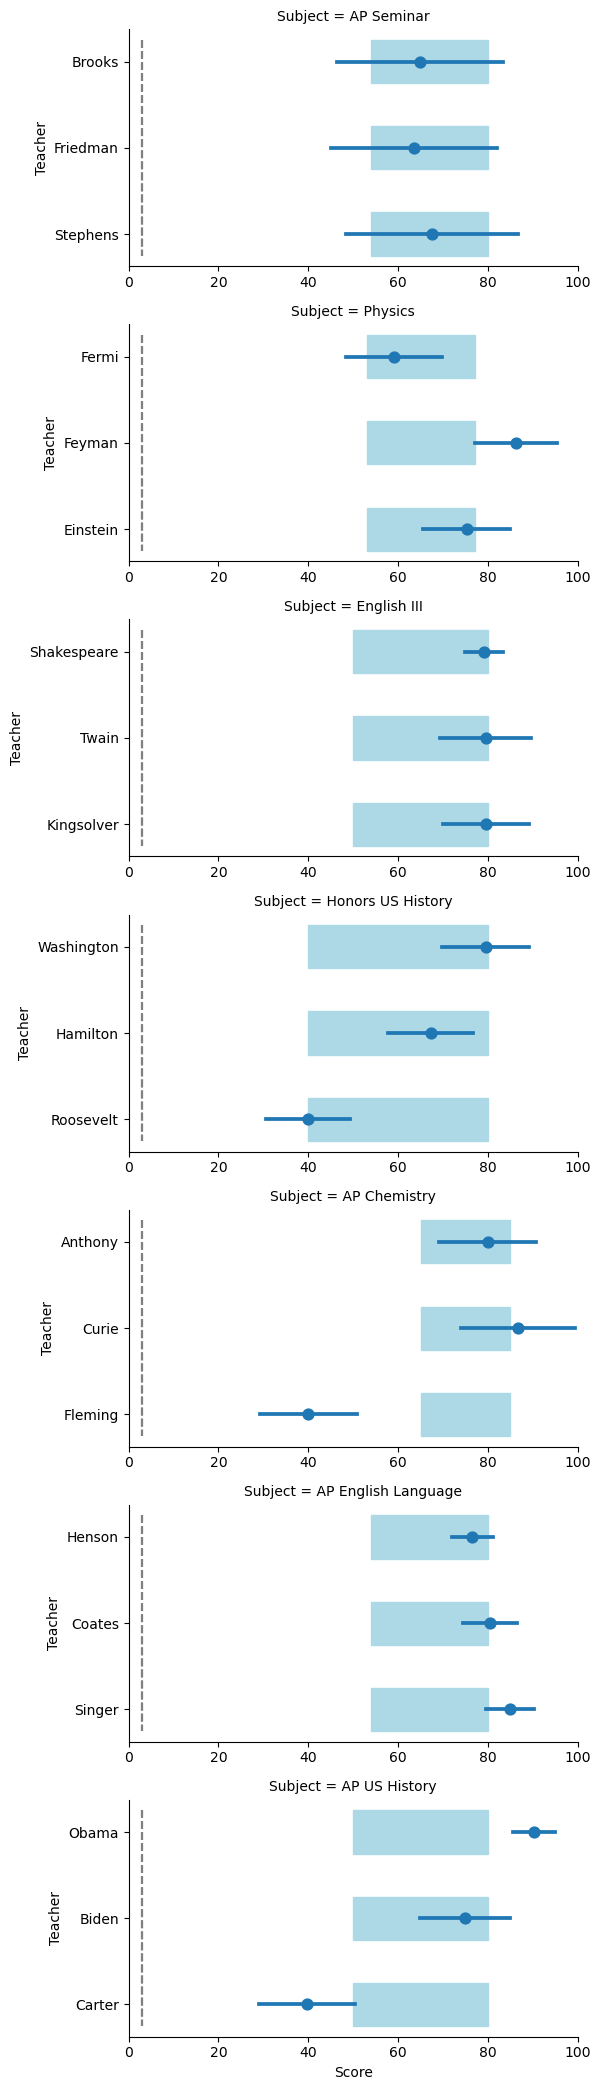

In [10]:
df_sub = df[~df.Subject.isin(["Environmental Science", "Computer Science A", "English Language & Comp", "English Literature & Comp", "Government & Politics - U.S.", "Chemistry"])]


order = df_sub[["Subject", "Score"]].groupby(by="Subject").mean()
order = order.sort_values(by="Score", ascending=False)
order = order.index

df_sub.loc[:,"Subject"] = pd.Categorical(df_sub["Subject"], categories=order, ordered=True)

g = sns.FacetGrid(df_sub, col="Subject", col_wrap=1, sharey=False, aspect=2, sharex=False, 
                  legend_out=False)
g.map(sns.pointplot, "Score", "Teacher", linestyles="none", errorbar='sd')

g.set(xlim=(0,100))

ax = g.axes[0]
#ax.set_xticklabels(["",1,2,3,4,5,""])

for ax, Subject in list(zip(g.axes, list(order))):
  labels = ax.yaxis.get_ticklabels()
  for label in labels:
    national_ave = df_cb.loc["Mean Score", Subject]
    national_std = df_cb.loc["Standard Deviation", Subject]
    position = label.get_position()
    rect = patches.Rectangle((national_ave-national_std, position[1]-0.25), 
                             2*national_std, 0.5, facecolor='#ADD8E6', edgecolor='#ADD8E6')
    ax.add_patch(rect)
    ax.vlines(x=3, ymin=-0.25, ymax=len(labels)-0.75, color="gray", linestyles='dashed')

g.savefig("Images/TeacherBreakdown.jpg")

## Consider Student Preparation
Finally, we consider the roll of student preparation for a course.  In classes that all students take, those who otherwise take the an "Honors Track" courseload do better than those in the "General Track".  

In [12]:
tracked_courses = ["AP English Language", "AP Chemistry", "AP US History"]

tracked_students = df.loc[df.Subject.isin(tracked_courses), "Student_Number"]
tracked_students = tracked_students.unique()

df["Tracked_Student"] = df["Student_Number"].apply(lambda x: "Honors Track" if x in tracked_students else "General Track")

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_13215/2006321471.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub2["Subject2"] = pd.Categorical(df_sub2["Subject"], categories=order, ordered=True)
/Users/jgoett/anaconda3/envs/jeff-env/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


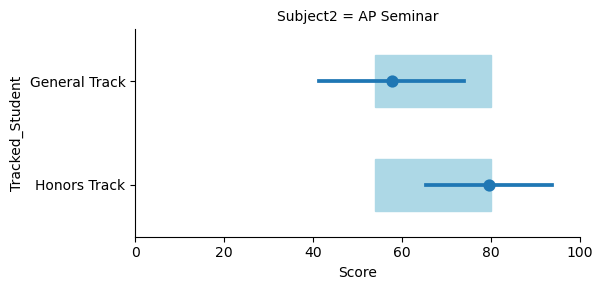

In [13]:
focus_classes = ["AP Seminar"]
df_sub2 = df.loc[df.Subject.isin(focus_classes)]

order = df_sub2[["Subject", "Score"]].groupby(by="Subject").mean()
order = order.sort_values(by="Score", ascending=False)
order = order[~order.Score.isna()]
order = order.index

df_sub2["Subject2"] = pd.Categorical(df_sub2["Subject"], categories=order, ordered=True)

g = sns.FacetGrid(df_sub2, col="Subject2", col_wrap=1, sharey=False, aspect=2, sharex=False, 
                  legend_out=False)

g.map(sns.pointplot, "Score", "Tracked_Student", linestyles="none", errorbar='sd')

g.set(xlim=(0,100))


for ax, Subject in list(zip(g.axes, list(order))):
  labels = ax.yaxis.get_ticklabels()
  for label in labels:
    national_ave = df_cb.loc["Mean Score", Subject]
    national_std = df_cb.loc["Standard Deviation", Subject]
    position = label.get_position()
    rect = patches.Rectangle((national_ave-national_std, position[1]-0.25), 
                             2*national_std, 0.5, facecolor='#ADD8E6', edgecolor='#ADD8E6')
    ax.add_patch(rect)

g.savefig("Images/StudentPreparation.jpg")

## Conclusion
In summary, we see that student performance in classes can be dependent on **curriculum**, **teacher assignment**, and **student preparation**.  Student performance could potentially be improved by addressing each issue appropriately.